# Boxplot 

This script plots the boxplot of areas of high anthropogenic pollution in the Northern in DJF and JJA

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
sns.set(style="whitegrid")

def open_nc(path):
    ds = xr.open_dataset(path)
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
    ds = ds.reindex(lon=sorted(ds.lon))
    return ds

In [2]:
ds = open_nc("../nc_files/f09.nc")

# create masks based on percentile for chi
ds["opt1_per"] = ds["s1_opt1"]/(ds["s1_opt1"]+ds["s2_opt1"])
ds["hyg_per"] = ds["s1_hyg"]/(ds["s1_hyg"]+ds["s2_hyg"])
ds["Mass_all"] = ds["Mass_bc"]+ds["Mass_dst"]+ds["Mass_ncl"]+ds["Mass_pom"]+ds["Mass_soa"]+ds["Mass_so4"]
for var in ["bc","dst","ncl","pom","soa","so4"]:
    ds[var+"_per"]=ds["Mass_"+var]/ds["Mass_all"]

ds=ds[["chi_abd","chi_opt1","chi_hyg",
       "opt1_per","hyg_per",
       "bc_per","dst_per","ncl_per","pom_per","soa_per","so4_per",
       "Mass_bc","Mass_dst","Mass_ncl","Mass_pom","Mass_soa","Mass_so4"]]

ds["polluted"] = ds["Mass_bc"]+ds["Mass_pom"]+ds["Mass_soa"]+ds["Mass_so4"]

In [3]:
ds["mask"] = xr.DataArray(np.ones(ds["bc_per"].shape), 
                          coords = [ds.lat, ds.lon, ds.season],
                          dims = ["lat","lon","season"])

In [4]:
ds["mask_chi_abd"] = ds["mask"].where((ds["bc_per"]<0.975)&(ds["dst_per"]<0.975)\
                                    &(ds["ncl_per"]<0.975)&(ds["pom_per"]<0.975)\
                                    &(ds["soa_per"]<0.975)&(ds["so4_per"]<0.975))\
                                    .notnull().squeeze()

ds["mask_chi_opt1"] = ds["mask"].where((ds["bc_per"]>0.01)&(ds["bc_per"]<0.99))\
                                .notnull().squeeze()

ds["mask_chi_hyg"] = ds["mask"].where(((ds["bc_per"]+ds["dst_per"]+ds["pom_per"])>0.025)\
                                &((ds["bc_per"]+ds["dst_per"]+ds["pom_per"])<0.975))\
                               .notnull().squeeze()


,count,mean,std,min,25%,50%,75%,max
chi_abd,2152.0,-1.844875,10.277228,-36.4408,-7.612736,-0.320225,5.691972,25.079514


,count,mean,std,min,25%,50%,75%,max
chi_opt1,2062.0,0.231896,6.408307,-18.62019,-4.840786,0.222702,5.199512,20.502548


,count,mean,std,min,25%,50%,75%,max
chi_hyg,2123.0,3.610234,8.01912,-21.929905,-2.454784,3.224697,9.493402,29.949493


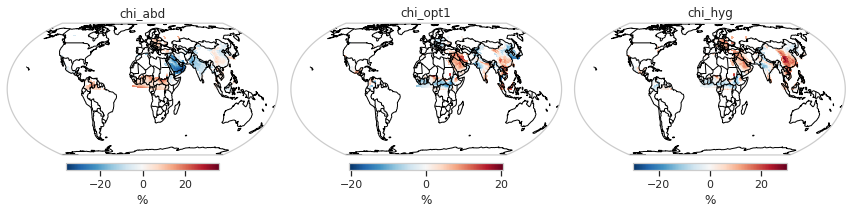

In [5]:
ds["mask_high_polluted"] = ds["mask"].where((ds["polluted"]>(ds["polluted"].quantile(0.90))))\
                                .notnull().squeeze()

map_dict = {}
i=1
fig = plt.figure(figsize=(12,3))

for chi in ["chi_abd", "chi_opt1", "chi_hyg"]:
#     print(chi)
    map_dict[chi+"_JJA"] = ds[chi].where(ds["mask_"+chi])\
                      .where(ds["mask_high_polluted"]).where(ds.lat>=0).sel(season="JJA")
    map_dict[chi+"_DJF"] = ds[chi].where(ds["mask_"+chi])\
                      .where(ds["mask_high_polluted"]).where(ds.lat>=0).sel(season="DJF")
    map_dict[chi+"_JJA_DJF"] = map_dict[chi+"_JJA"]-map_dict[chi+"_DJF"]
    
    ax = plt.subplot(1,3,i, projection = ccrs.EqualEarth())
    
    map_dict[chi+"_JJA_DJF"].plot(ax=ax, 
                                  cbar_kwargs={'label': r'%',
                                         'orientation':'horizontal',
                                         'fraction':0.05,
                                         'pad':0.05},
                                  transform = ccrs.PlateCarree(),
                                  rasterized=True)
    display(map_dict[chi+"_JJA_DJF"].to_dataframe().describe()[[chi]].transpose())
    
    ax.set_global() 
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS)
    ax.set_title(chi)
    i=i+1
#     print("\n")
plt.tight_layout()
# plt.savefig('../../figures/high_polluted_summer.pdf',dpi=600)
plt.show()

In [6]:
df_JJA = {}
mask_temp = ds["mask_high_polluted"].sel(season="DJF")\
.to_dataframe()[["mask_high_polluted"]].reset_index()
df_JJA["mask"] = mask_temp[mask_temp["mask_high_polluted"]==True]

df_DJF = {}
mask_temp = ds["mask_high_polluted"].sel(season="JJA")\
.to_dataframe()[["mask_high_polluted"]].reset_index()
df_DJF["mask"] = mask_temp[mask_temp["mask_high_polluted"]==True]

for chi in ["chi_abd", "chi_opt1", "chi_hyg"]:    
    df_JJA[chi] = map_dict[chi+"_JJA"].to_dataframe().drop(columns=["quantile"])
    df_DJF[chi] = map_dict[chi+"_DJF"].to_dataframe().drop(columns=["quantile"])

In [7]:
def merge_chi(df_dict):
    abd_opt1 = df_dict["chi_abd"].merge(df_dict["chi_opt1"],
                                        on=["lat","lon","season"],
                                        how="outer")
    abd_opt1_hyg = abd_opt1.merge(df_dict["chi_hyg"],
                                  on=["lat","lon","season"],
                                  how="outer")
    
    merge_df = df_dict["mask"].merge(abd_opt1_hyg.reset_index(), 
                                     on = ["lat","lon"],how="inner")
    
    return merge_df

count       mean       std        min        25%  \
mixing_state_type season                                                      
chi_abd           DJF     2152.0  63.852253  7.753978  34.050770  61.133967   
                  JJA     2152.0  62.007378  9.320025  26.759422  58.433241   
chi_hyg           DJF     2142.0  48.734802  6.895618  30.157143  43.717027   
                  JJA     2129.0  52.350456  5.001290  37.129204  49.009560   
chi_opt1          DJF     2092.0  74.509483  8.480309  48.859158  69.983713   
                  JJA     2063.0  74.841064  6.648613  49.561859  70.674156   

                                50%        75%        max  
mixing_state_type season                                   
chi_abd           DJF     65.572590  68.707474  90.179764  
                  JJA     62.774906  67.639643  83.677032  
chi_hyg           DJF     48.615936  53.969230  68.753548  
                  JJA     52.394871  55.780174  67.320312  
chi_opt1          DJF     75.114643  80.185080  92.969177  
                  JJA     75.439110  79.898453  89.123055

,count,mean,std,min,25%,50%,75%,max
mixing_state_type,,,,,,,,
chi_abd,4304.0,62.929817,8.621342,26.759422,59.149146,64.441635,68.293638,90.179764
chi_hyg,4271.0,50.537125,6.290947,30.157143,46.257311,50.863323,55.115902,68.753548
chi_opt1,4155.0,74.674110,7.626933,48.859158,70.346745,75.253448,79.958237,92.969177


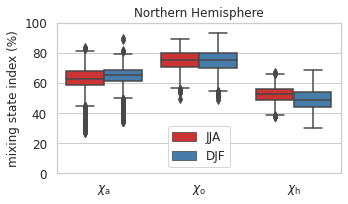

In [8]:
JJA_merge = merge_chi(df_JJA).drop(columns=["mask_high_polluted"])
DJF_merge = merge_chi(df_DJF).drop(columns=["mask_high_polluted"])
df_mask = pd.concat([JJA_merge,DJF_merge]).reset_index(drop=True)
merge_data_new = df_mask.set_index(["lat","lon","season"]).stack()\
.reset_index(name="mixing_state_index")\
.rename(columns={'level_3':'mixing_state_type'})


north = merge_data_new[merge_data_new["lat"]>=0]
rc={'axes.labelsize': 12,
    'font.size': 12, 'legend.fontsize': 12, 
    'axes.titlesize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12}
plt.rcParams.update(**rc)

figure = plt.figure(figsize = (5,3))
ax = plt.subplot(111)
s=sns.boxplot(x="mixing_state_type", 
              ax=ax,
              y="mixing_state_index", 
              hue="season", 
              data=north,
              order = ["chi_abd","chi_opt1","chi_hyg"],
              palette="Set1")
ax.set_title("Northern Hemisphere")
ax.set_ylim([0, 100]) 
ax.set_ylabel("mixing state index (%)")
ax.set_xlabel("")
s.set(xticklabels=[r"$\chi_{\rm{a}}$",
                   r"$\chi_{\rm{o}}$",
                   r"$\chi_{\rm{h}}$",])
ax.legend(loc='lower center')
plt.tight_layout()
plt.savefig("../../figures/mixing_state_boxplot.pdf")

display(north.groupby(["mixing_state_type","season"])["mixing_state_index"].describe())
display(north.groupby(["mixing_state_type"])["mixing_state_index"].describe())